In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

sys.path.append('../3_analyze')
from containers import Dataset
from statistics import *
from prob_opt import PredictStructs
from utils import export, show_side_by_side, show_features

# Settings

In [2]:
data = '/scratch/PI/rondror/jbelk/method/data/'
ifp_dir = 'ifp/ifp1'
mcss_dir = 'mcss/mcss7'
glide_dir = 'docking/glide12'
num_stats_ligs = 5
num_stats_poses = 20
smooth = 0.2
struct_dict = {'D2R':'6CM4','AR':'2PNU','B1AR':'2VT4',
               'TRPV1':'3J5Q','SIGMA1':'5HK1','5HT2B':'4IB4','DTRANSP':'4M48',
               'M3':'4U15'}

features = {
    'mcss':[],
    'hbond':[2,3],
    'sb':[4],
    'pipi':[6],
    #'picat':[7,8],
    #'contact':[11]
}

# Plot Statistics

In [3]:
stats_prots = struct_dict
stats_data = Dataset(stats_prots, data, glide_dir, ifp_dir, mcss_dir)
stats_data.load({p:prot.lm.pdb for p,prot in stats_data.proteins.items()})

warning, only 2 ligands found for 5HT2B


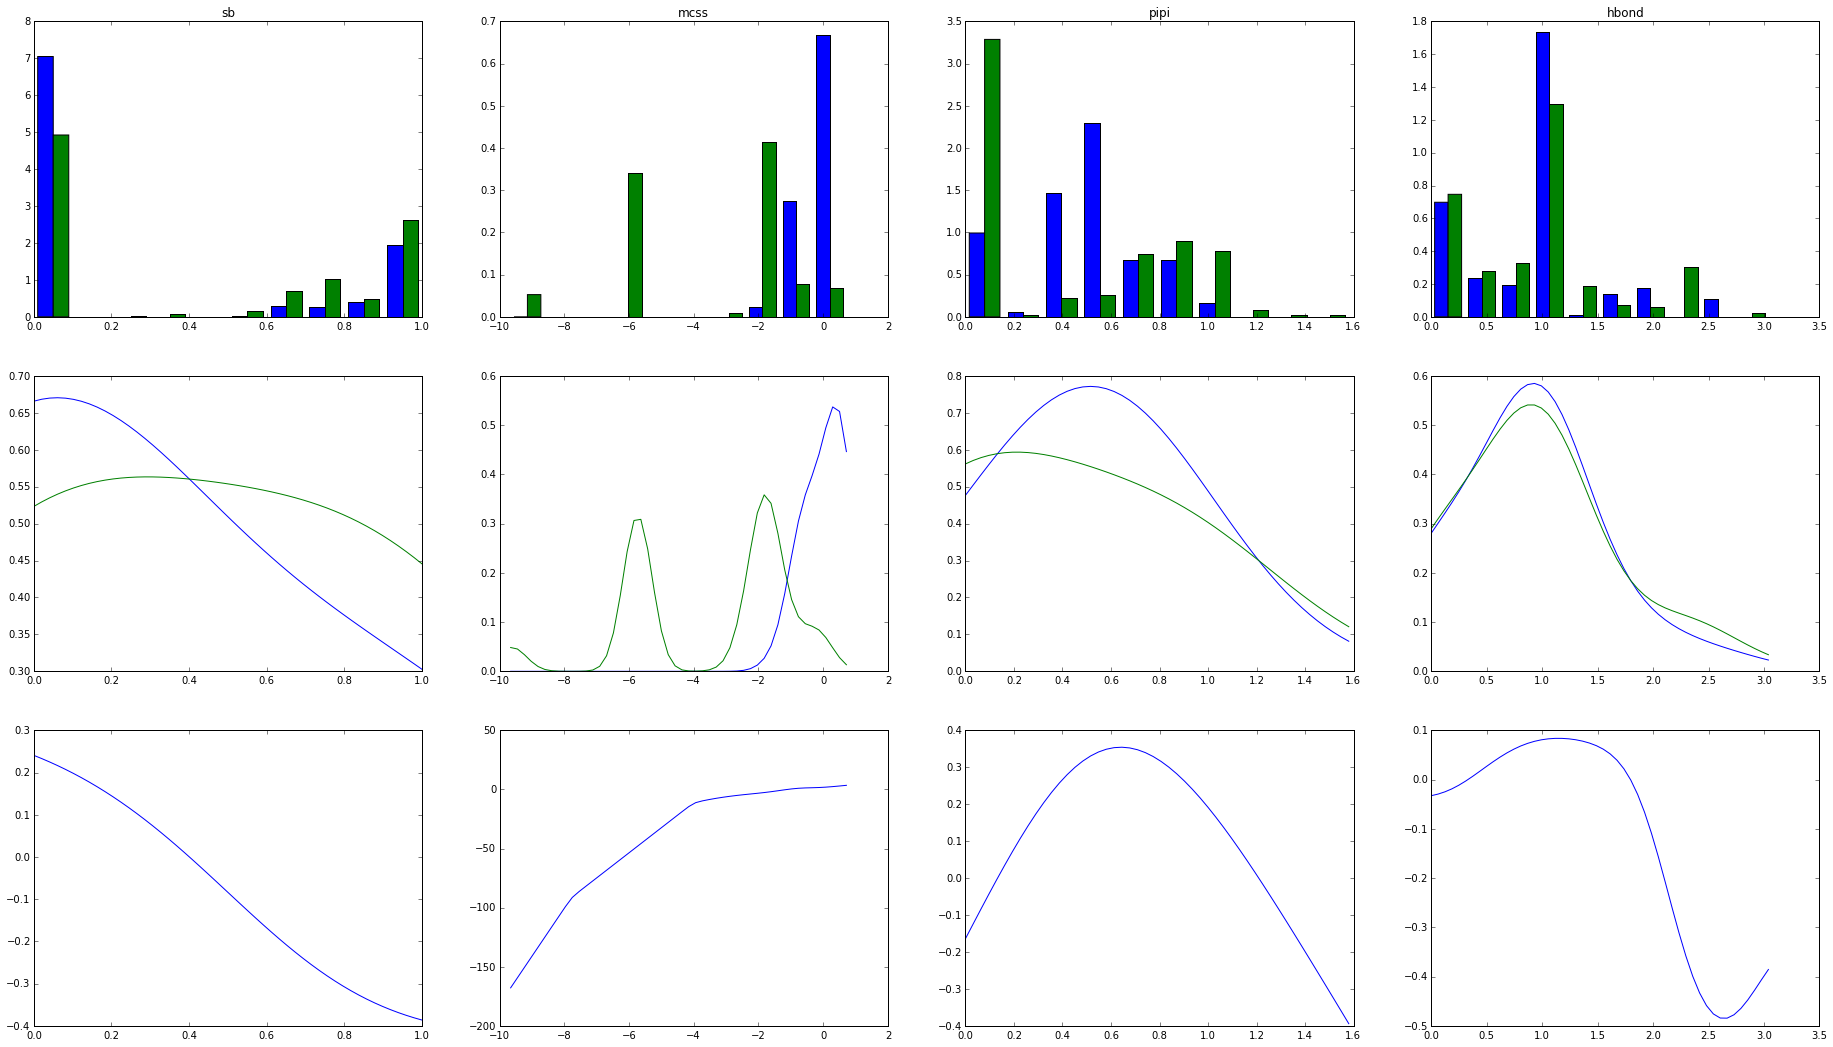

In [4]:
def plot_statistics(evidence, points = 50):
    
    fig, ax = plt.subplots(3, len(evidence.features),
                           figsize=(len(evidence.features)*8, 18))
    
    for i, feature in enumerate(features):
        data = evidence.raw_data[feature][-1]
        if not len(data): continue
        low, high = min(data), max(data)
        X = np.linspace(low, high, points)
        native = map(lambda x: evidence.evaluate(feature, x, 1), X)
        decoy  = map(lambda x: evidence.evaluate(feature, x, 0), X)
        log_ratio = np.log(native) - np.log(decoy)
        
        ax[0, i].set_title(feature)
        ax[0, i].hist([evidence.raw_data[feature][1],
                       evidence.raw_data[feature][0]], normed = True)
        
        ax[1, i].plot(X, native)
        ax[1, i].plot(X, decoy)
        
        ax[2, i].plot(X, log_ratio)

statistics = Statistics(stats_data, stats_prots, 
                        num_stats_ligs, num_stats_poses, 
                        features, smooth, False)
plot_statistics(statistics.evidence)

warning, only 2 ligands found for 5HT2B


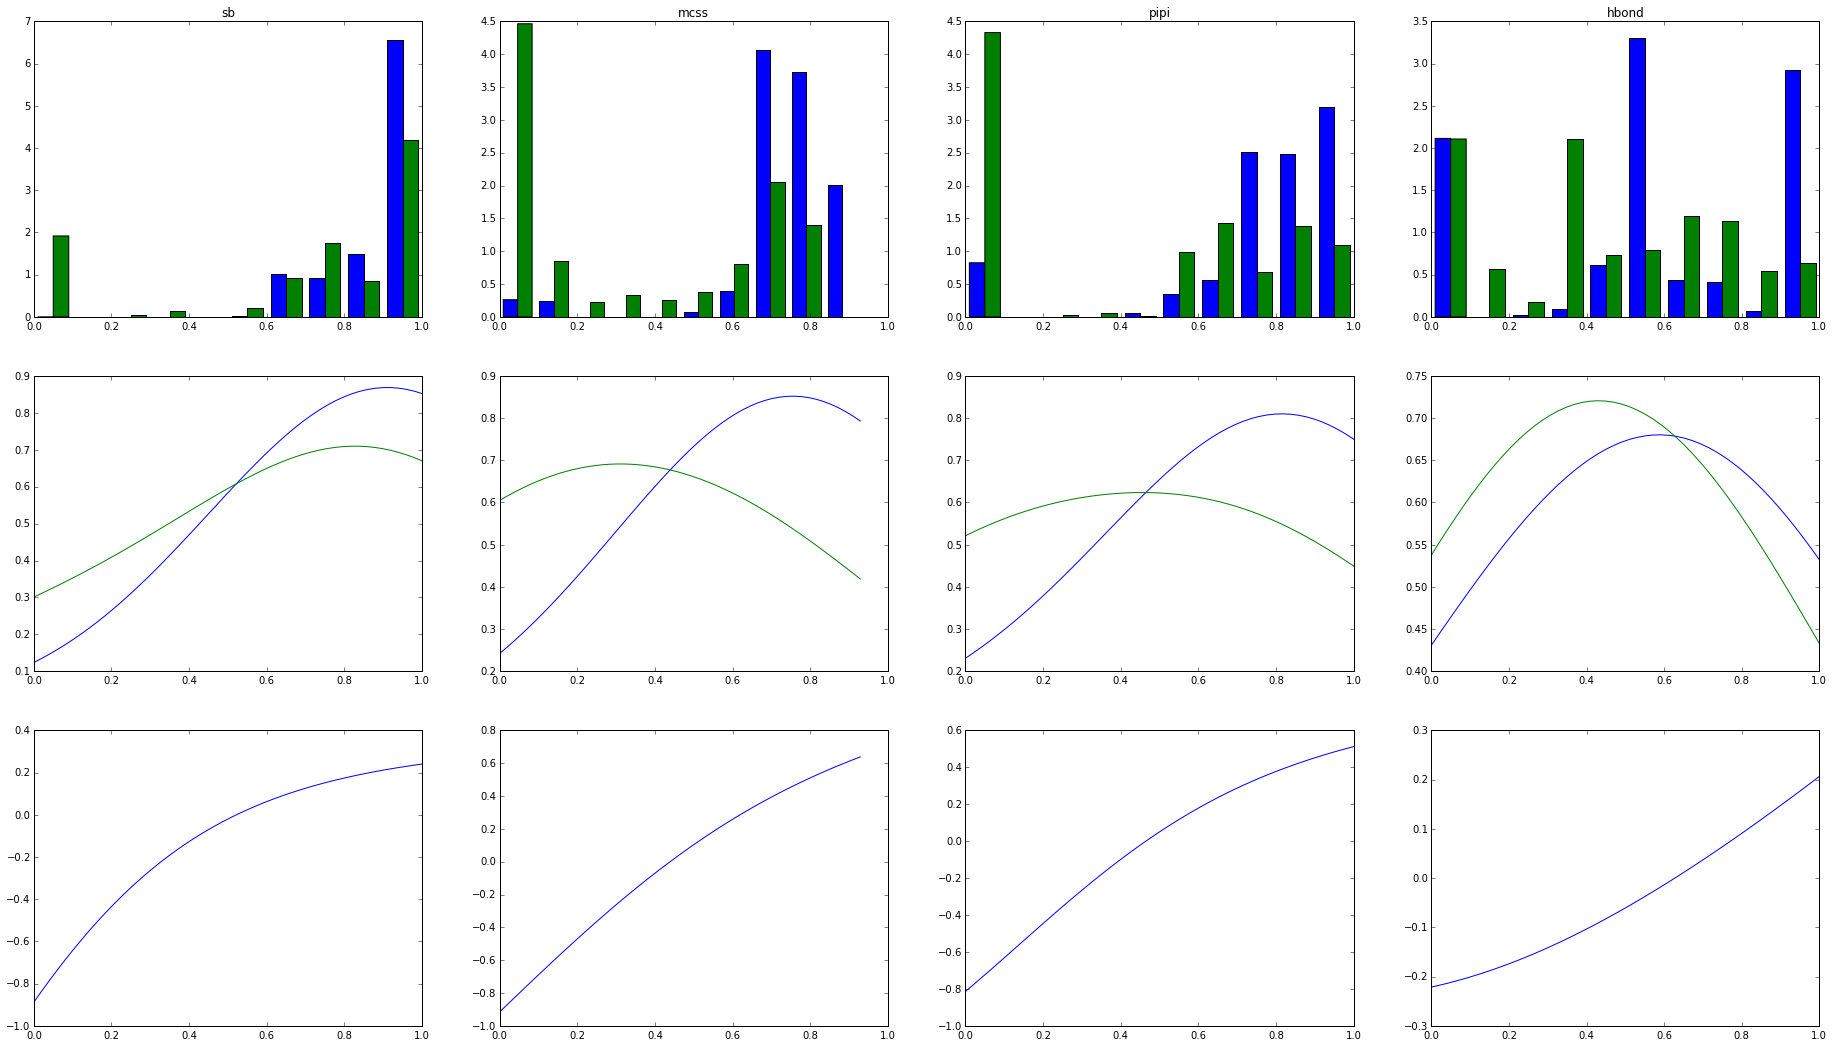

In [5]:
statistics = Statistics(stats_data, stats_prots, 
                        num_stats_ligs, num_stats_poses, 
                        features, smooth, True)
plot_statistics(statistics.evidence)

# Benchmark on crystallographic ligands

In [8]:
def benchmark(ref, num_poses, t, smooth, normalize_fp, optimization = 'MAX', sampling = 3):
    proteins, glides, combinds = [], [], []
    for protein in stats_data.proteins:
        docking = stats_data.proteins[protein].docking[struct_dict[protein]]
        statistics = Statistics(stats_data, {k:v for k, v in stats_prots.items() if k != protein}, 
                                num_stats_ligs, num_stats_poses, 
                                features, smooth, normalize_fp)
        ps = PredictStructs(docking, statistics.evidence, 
                            features, num_poses, t, ref, normalize_fp)
        l_list = sorted(stats_data.proteins[protein].lm.pdb)[:20]
        best_cluster, _ = ps.find_best_cluster(l_list, sampling, optimization)

        us_top    = ps.get_poses(best_cluster)
        glide_top = ps.get_poses({l:0 for l in best_cluster})
        
        combinds += [np.array([po.rmsd for l,po in us_top.items()])]
        glides  += [np.array([po.rmsd for l,po in glide_top.items()])]
        proteins += [protein]
    return proteins, glides, combinds

class Table:
    def __init__(self, columns):
        self.columns = columns
    
    def __call__(self, data):
        s = ''
        for width, d in zip(self.columns, data):
            s += str(d).ljust(width, ' ')
        print s

def summarize(proteins, glides, combinds):
    table = Table([13]* 6)
    table(['Protein', 'Glide RMSD', 'ComBind RMSD', 'Glide Low', 'ComBind Low', 'Tied'])
    for protein, glide, combind in zip(proteins, glides, combinds):
        
        table([protein, round(np.mean(glide), 4), round(np.mean(combind), 4),
               np.sum(glide < combind), np.sum(glide > combind), np.sum(glide == combind)])

In [10]:
proteins, glides, combinds = benchmark('ALL', 100, 1, smooth, False, 'MAX', 3)
summarize(proteins, glides, combinds)

warning, only 2 ligands found for SIGMA1
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
Protein      Glide RMSD   ComBind RMSD Glide Low    ComBind Low  Tied         
5HT2B        1.1509       1.1509       1            1            0            
TRPV1        3.5045       1.8212       0            1            1            
D2R          5.8818       8.4288       3            3            1            
AR           2.8762       1.8243       11           9            0            
M3           0.8647       0.8647       0            0            2            
DTRANSP      3.0923       1.996        3            5            1            
B1AR         2.8616       1.64         3            6            3            
SIGMA1       0.9715       5.0897       1       

In [9]:
proteins, glides, combinds = benchmark('ALL', 100, 1, smooth, True, 'MAX', 3)
summarize(proteins, glides, combinds)

warning, only 2 ligands found for SIGMA1
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
Protein      Glide RMSD   ComBind RMSD Glide Low    ComBind Low  Tied         
5HT2B        1.1509       1.5937       1            1            0            
TRPV1        3.5045       3.5045       0            0            2            
D2R          5.8818       3.9448       2            4            1            
AR           2.8762       1.8552       6            12           2            
M3           0.8647       0.8647       0            0            2            
DTRANSP      3.0923       1.7414       2            4            3            
B1AR         2.8616       2.0448       4            4            4            
SIGMA1       0.9715       0.9715       0       

In [11]:
proteins, glides, combinds = benchmark('DECOY', 100, 1, smooth, True, 'MAX', 3)
summarize(proteins, glides, combinds)

warning, only 2 ligands found for SIGMA1
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
Protein      Glide RMSD   ComBind RMSD Glide Low    ComBind Low  Tied         
5HT2B        1.1509       1.5937       1            1            0            
TRPV1        3.5045       3.5045       0            0            2            
D2R          5.8818       4.2532       3            4            0            
AR           2.8762       1.633        6            12           2            
M3           0.8647       0.8647       0            0            2            
DTRANSP      3.0923       2.0136       4            4            1            
B1AR         2.8616       1.4149       3            5            4            
SIGMA1       0.9715       0.9715       0       

In [12]:
proteins, glides, combinds = benchmark('LTP', 100, 1, smooth, True, 'MAX', 3)
summarize(proteins, glides, combinds)

warning, only 2 ligands found for SIGMA1
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
Protein      Glide RMSD   ComBind RMSD Glide Low    ComBind Low  Tied         
5HT2B        1.1509       1.5937       1            1            0            
TRPV1        3.5045       3.5045       0            0            2            
D2R          5.8818       4.2532       3            4            0            
AR           2.8762       1.6099       6            12           2            
M3           0.8647       0.8647       0            0            2            
DTRANSP      3.0923       2.0136       4            4            1            
B1AR         2.8616       1.4149       3            5            4            
SIGMA1       0.9715       0.9715       0       

In [13]:
proteins, glides, combinds = benchmark('ALL', 100, 1, smooth, True, 'ANNEAL', 10)
summarize(proteins, glides, combinds)

warning, only 2 ligands found for SIGMA1
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
Protein      Glide RMSD   ComBind RMSD Glide Low    ComBind Low  Tied         
5HT2B        1.1509       1.5937       1            1            0            
TRPV1        3.5045       3.5045       0            0            2            
D2R          5.8818       3.8685       2            4            1            
AR           2.8762       1.5705       9            9            2            
M3           0.8647       0.8647       0            0            2            
DTRANSP      3.0923       1.7319       1            4            4            
B1AR         2.8616       1.4654       4            5            3            
SIGMA1       0.9715       0.9715       0       

In [14]:
proteins, glides, combinds = benchmark('ALL', 100, 1, smooth, True, 'GIBBS', 10)
summarize(proteins, glides, combinds)

warning, only 2 ligands found for SIGMA1
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
Protein      Glide RMSD   ComBind RMSD Glide Low    ComBind Low  Tied         
5HT2B        1.1509       1.5937       1            1            0            
TRPV1        3.5045       3.5817       1            0            1            
D2R          5.8818       4.7922       4            3            0            
AR           2.8762       1.9957       9            9            2            
M3           0.8647       0.3152       0            2            0            
DTRANSP      3.0923       2.4072       4            5            0            
B1AR         2.8616       1.9704       4            8            0            
SIGMA1       0.9715       5.773        2       

# Plot Features

In [15]:
protein = 'AR'
num_poses = 100
t = 10
ref = 'ALL'
sampling = 3
optimization = 'MAX'
normalize_fp = True


statistics = Statistics(stats_data, {k:v for k, v in stats_prots.items() if k != protein}, 
                        num_stats_ligs, num_stats_poses, 
                        features, smooth, normalize_fp)

docking = stats_data.proteins[protein].docking[struct_dict[protein]]
ps = PredictStructs(docking, statistics.evidence, 
                    features, num_poses, t, ref, normalize_fp)

l_list = sorted(stats_data.proteins[protein].lm.pdb)[:20]
best_cluster, _ = ps.find_best_cluster(l_list, sampling, optimization)

warning, only 2 ligands found for 5HT2B


sb x_k matrix


/share/PI/rondror/software/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


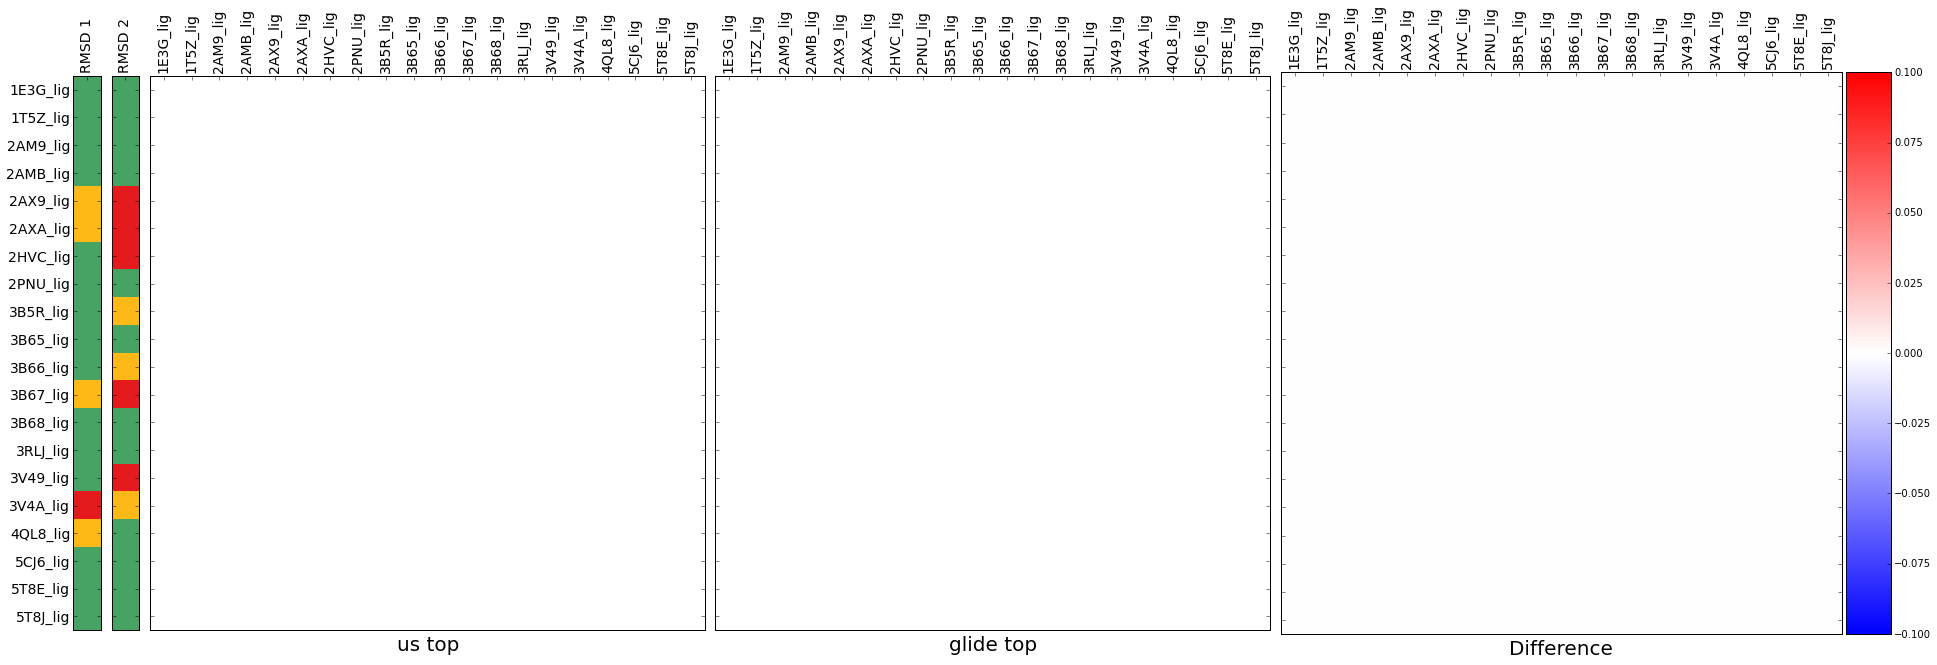

mcss probability matrix


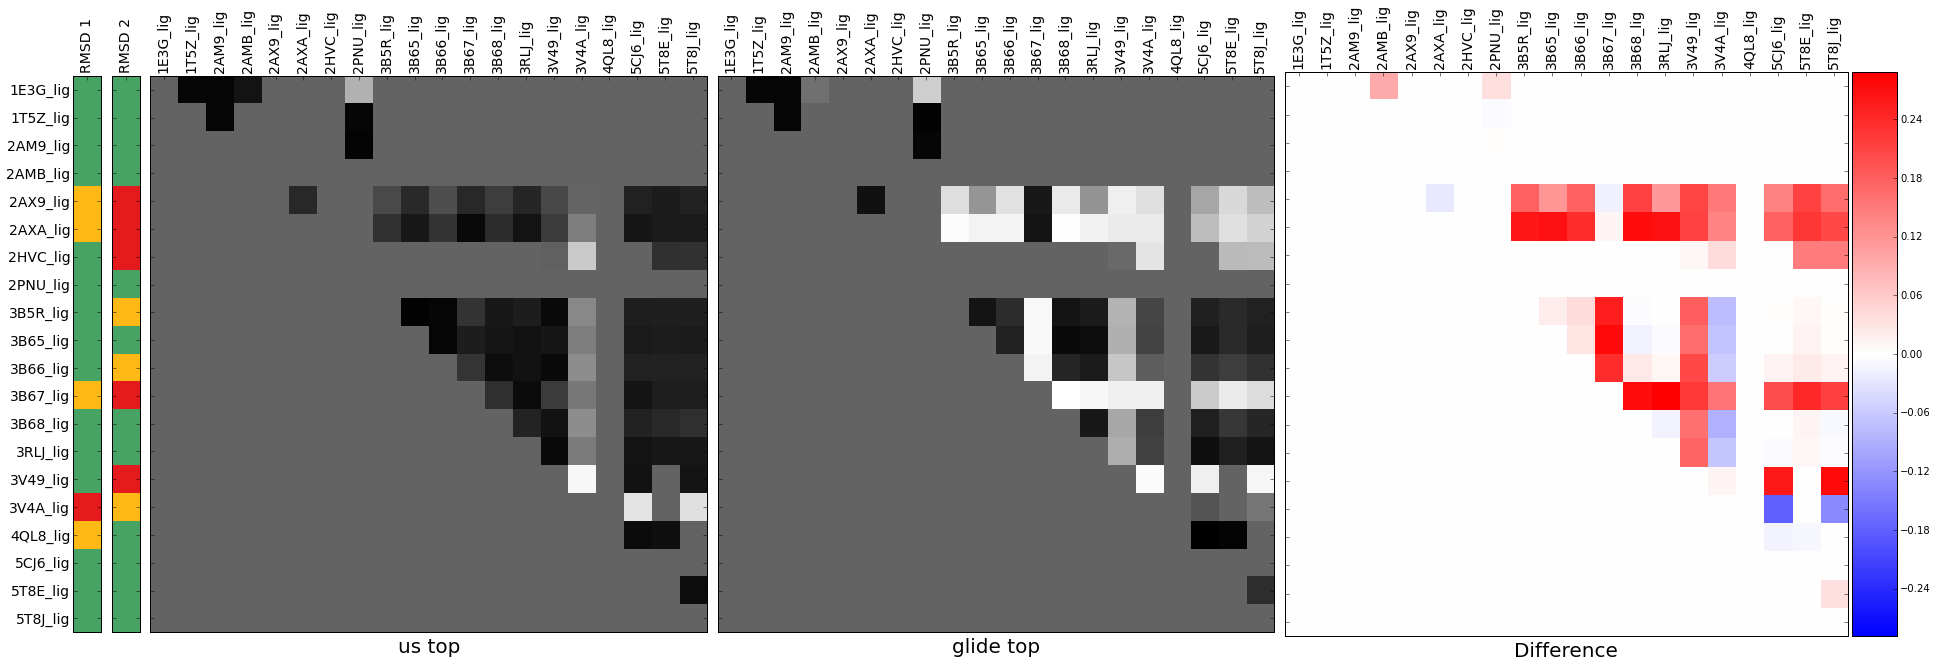

mcss x_k matrix


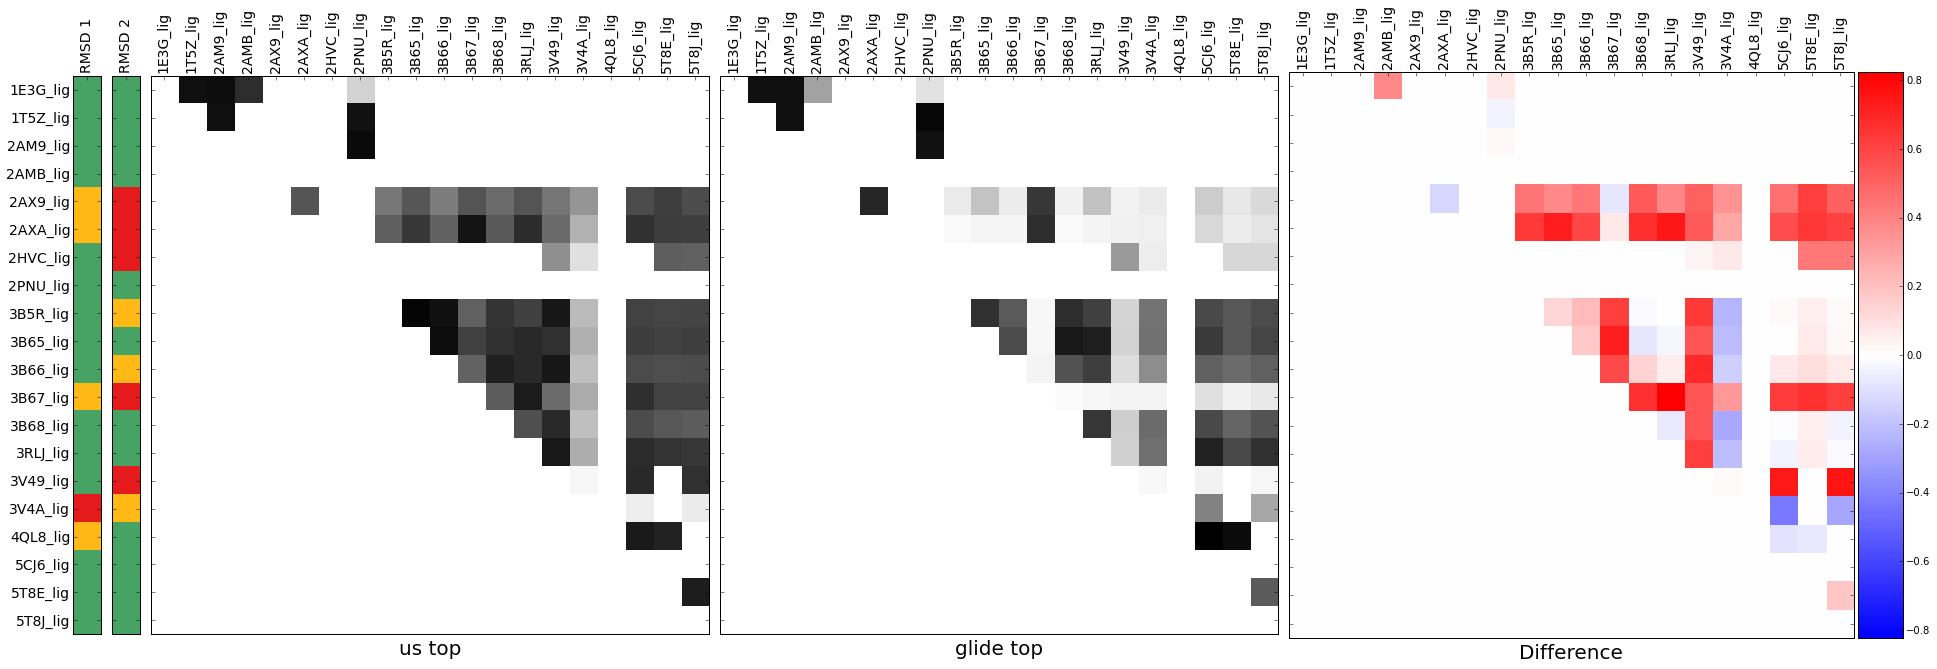

pipi probability matrix


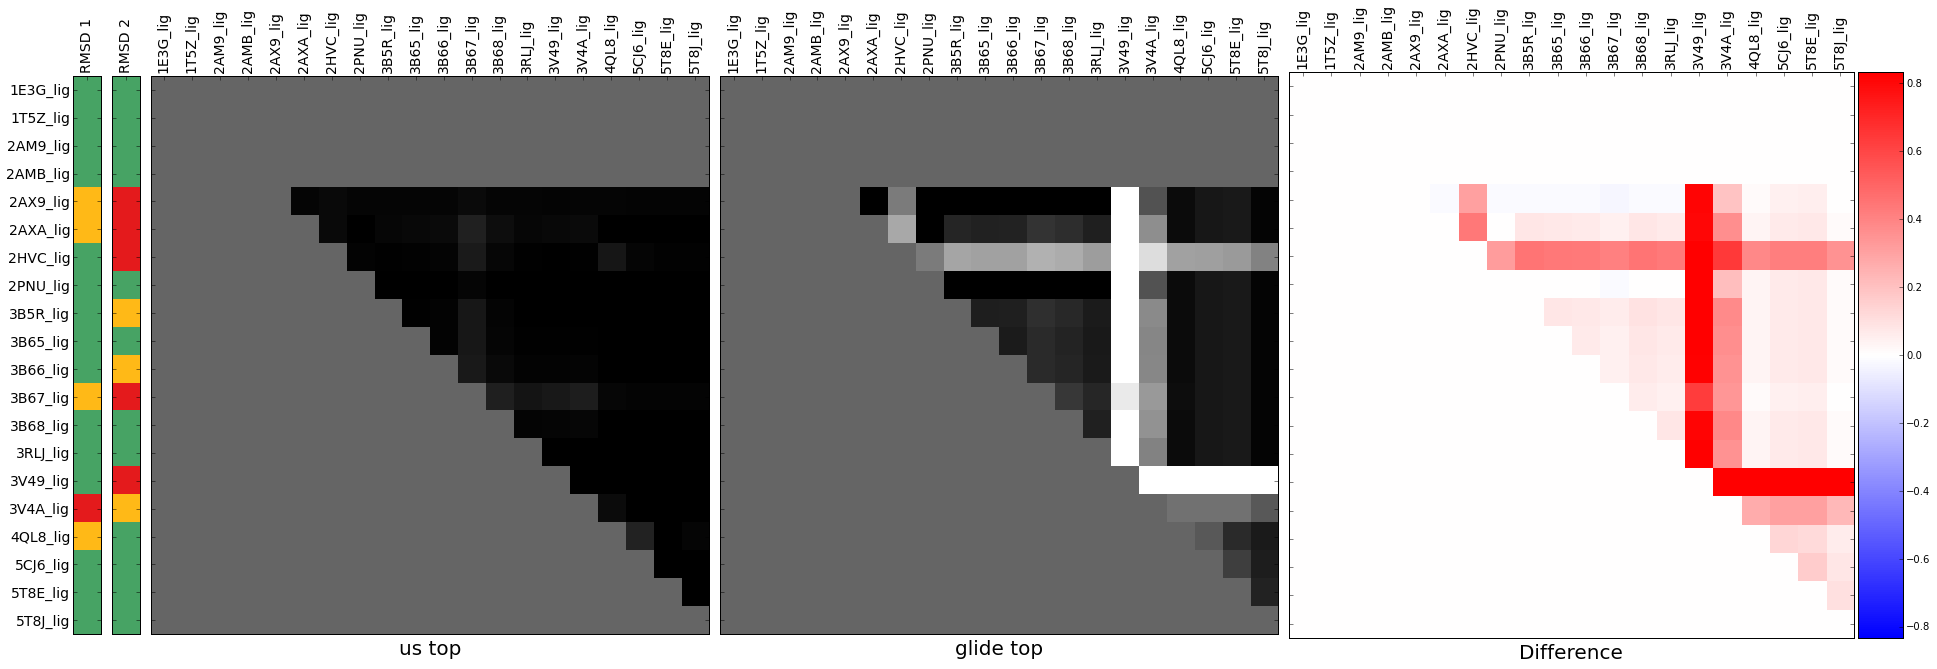

pipi x_k matrix


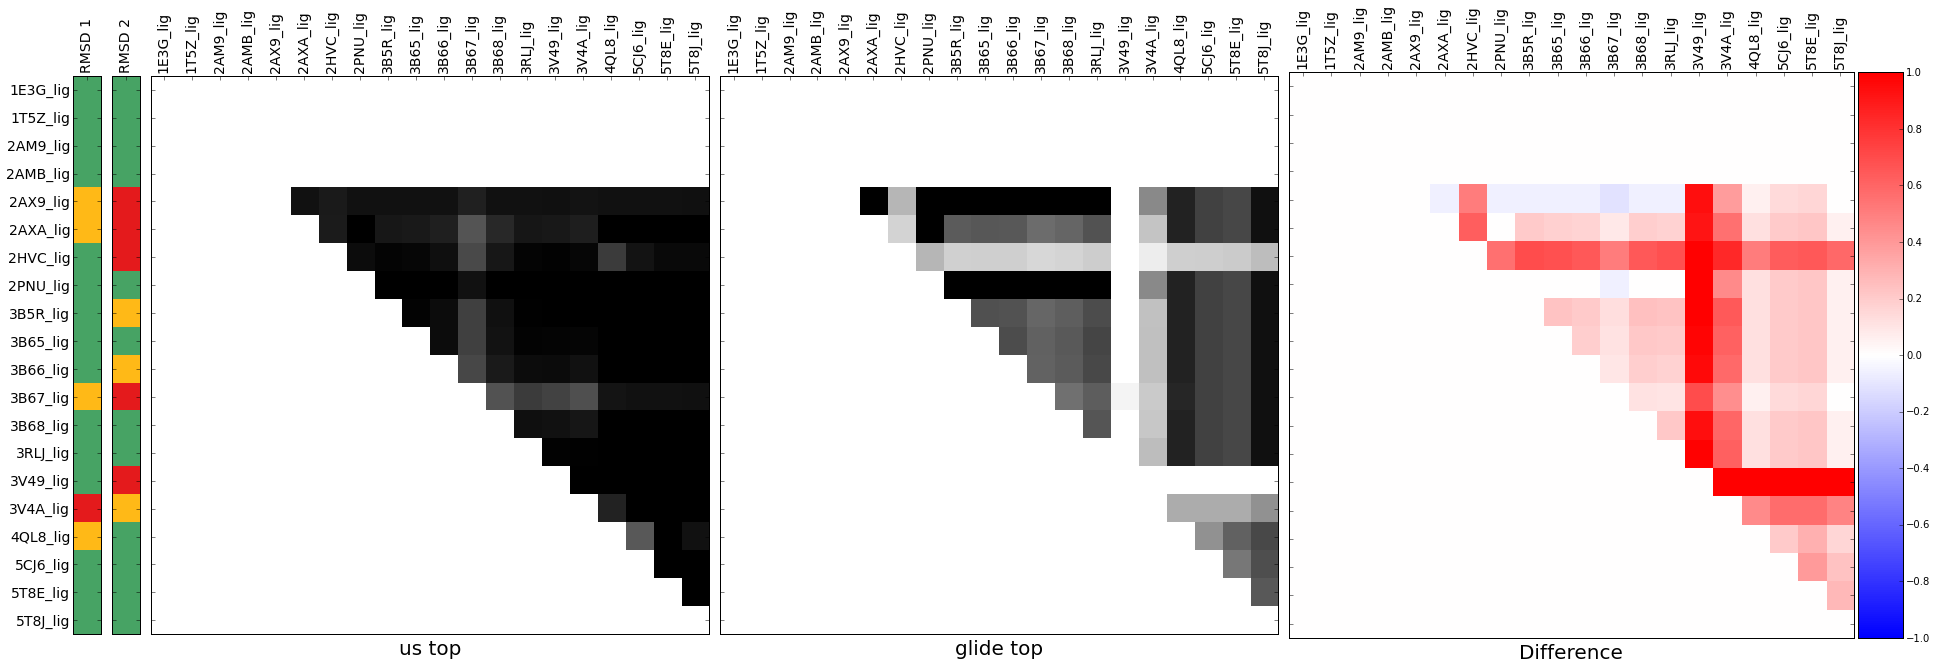

hbond probability matrix


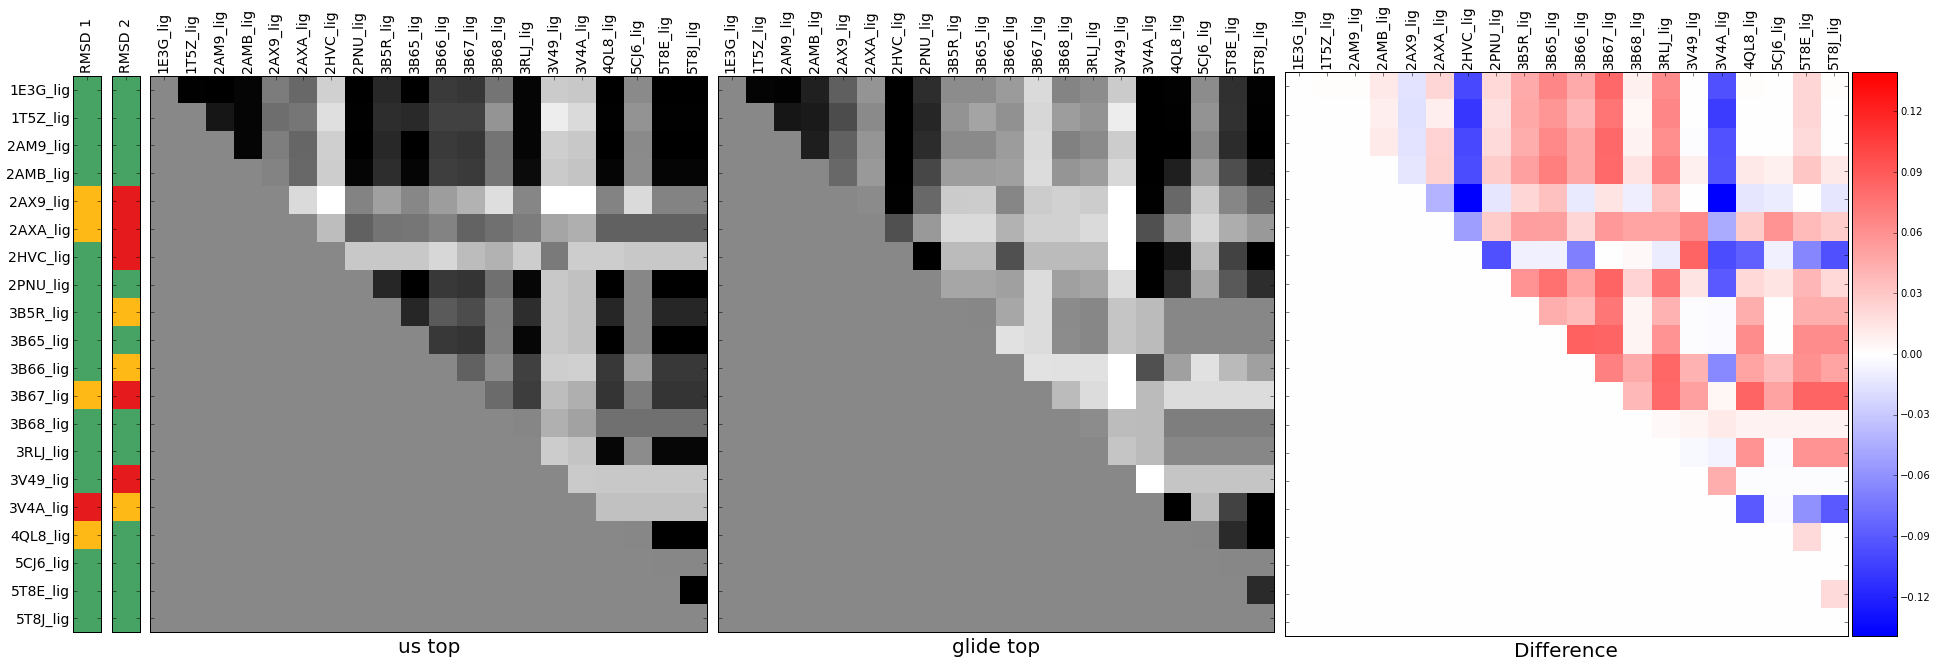

hbond x_k matrix


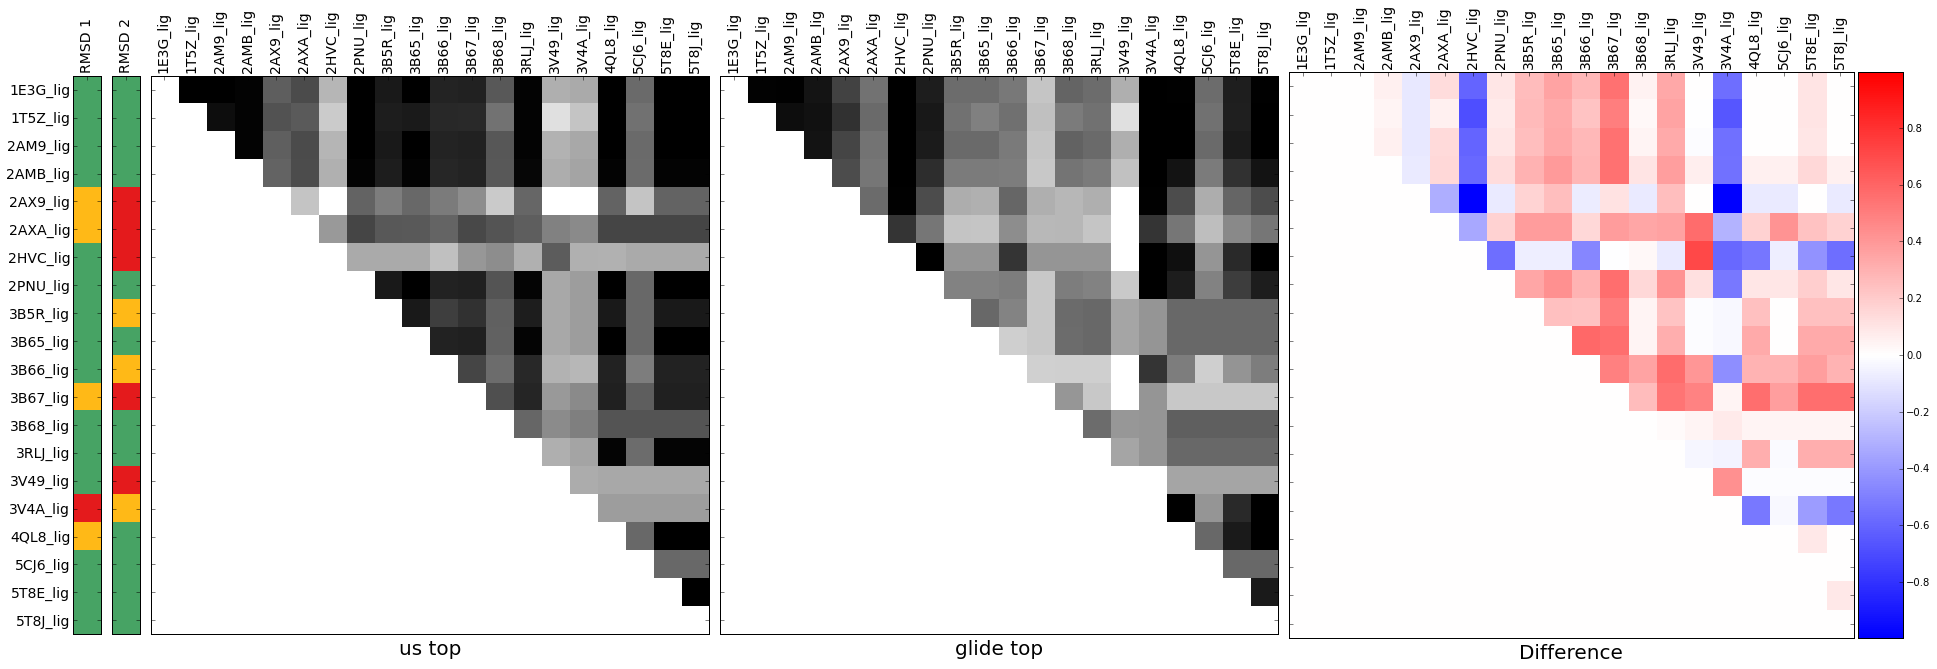

In [16]:
show_prob = True
show_x = True

us_top    = ps.get_poses(best_cluster)
glide_top = ps.get_poses({l:0 for l in best_cluster})

for k,kdef in features.items():
    x1, log_p1 = ps.likelihood_and_feature_matrix(best_cluster, k, l_list)
    x2, log_p2 = ps.likelihood_and_feature_matrix({l:0 for l in l_list}, k, l_list)
    
    if show_prob and np.sum(log_p1) != 0:
        print k, 'probability matrix'
        minval = min(np.min(log_p1[np.nonzero(log_p1)]),np.min(log_p2[np.nonzero(log_p2)]))
        maxval = max(np.max(log_p1[np.nonzero(log_p1)]),np.max(log_p2[np.nonzero(log_p2)]))
        
        show_features(us_top, log_p1, glide_top, log_p2, l_list, 'us top','glide top',size=1.5,mi=minval,ma=maxval)
        
    if show_x:
        print k, 'x_k matrix'
        minval = min(np.min(x1),np.min(x2))
        maxval = max(np.max(x1),np.max(x2))
    
        show_features(us_top, x1, glide_top, x2, l_list, 'us top','glide top',size=1.5,mi=minval,ma=maxval)